In [1]:
# COLMAP
%cd /notebooks
!pip install -q plyfile pycolmap Pillow==9.5.0 pycolmap plotly

!sudo apt-get update
!sudo apt-get install libglm-dev

!pip install -q /notebooks/diff-gaussian-rasterization
!pip install -q /notebooks/gaussian-splatting/submodules/simple-knn

!apt install imagemagick -y
# remove line 88 of vim ~/../etc/ImageMagick-6/policy.xml to run MoviePy
!sed -i '88d' ~/../etc/ImageMagick-6/policy.xml 

!sudo apt-get update && sudo apt-get install -y \
	ninja-build \
	libeigen3-dev \
	libflann-dev \
	libsqlite3-dev \
	libgl1-mesa-dev \
	cmake \
	libgoogle-glog-dev \
	libgflags-dev \
	libsuitesparse-dev \
	libceres-dev \
	libcgal-dev \
	libcgal-qt5-dev \
	libmetis-dev \
	libfreeimage-dev \
	libglew-dev

!sudo updatedb   # update the database used by locate
!locate Eigen3Config.cmake
!locate libflann

# # # Build COLMAP
# !git clone https://github.com/colmap/colmap.git
# %cd /notebooks/colmap
# !rm -rf build
# !mkdir build
# %cd /notebooks/colmap/build
# !cmake .. -DCMAKE_CUDA_ARCHITECTURES=native -GNinja

%cd /notebooks/colmap/build
!ninja
!sudo ninja install

# Check if colmap is installed
!colmap -h

%cd /notebooks


#HLOC
!pip install mediapy

# !rm -rf /notebooks/Hierarchical-Localization
# !git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/

%cd /notebooks/Hierarchical-Localization
!pip install --progress-bar off --quiet -e .


%cd /notebooks

/notebooks
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:5 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB] 
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]    
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3046 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3597 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [32.0 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1421 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Pa

In [2]:
# !rm -rf /notebooks/output
# !mkdir /notebooks/output


In [3]:
%cd /notebooks/Hierarchical-Localization
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval, colmap_from_nvm, pairs_from_exhaustive, pairs_from_covisibility
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import sys
sys.path.append('/notebooks/Hierarchical-Localization/third_party') 
sys.path.append('/notebooks/Hierarchical-Localization/third_party/d2net')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/deep-image-retrieval')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/r2d2')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/SuperGluePretrainedNetwork')
%cd /notebooks


%cd /notebooks
import glob
import os
import sys
import shutil
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from pathlib import Path
from time import time
import torch
import pycolmap

/notebooks/Hierarchical-Localization


/notebooks
/notebooks


/notebooks
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-li

,,,
,,,
,,,
,,,

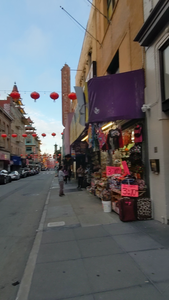
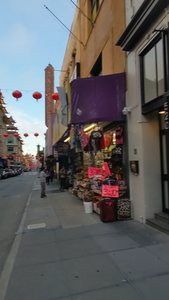
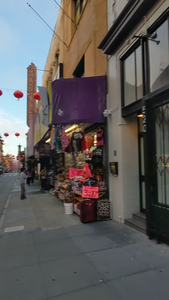
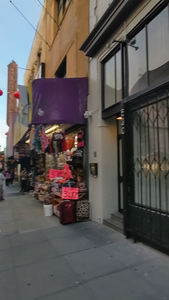
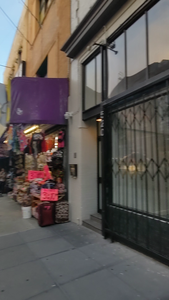
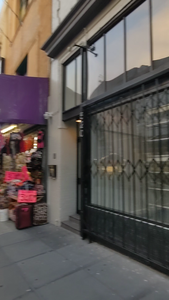
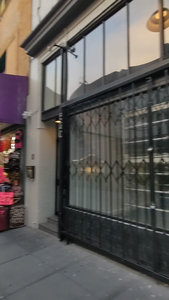
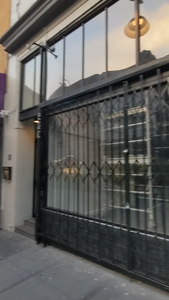
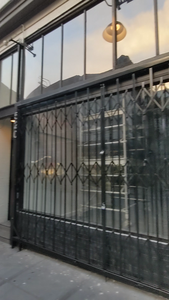
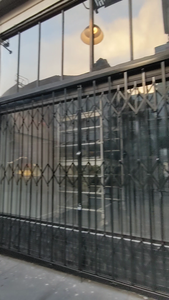
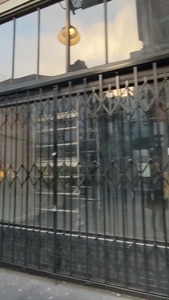
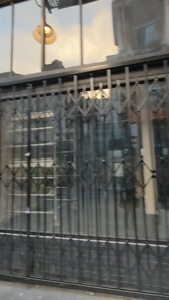
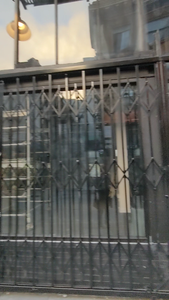
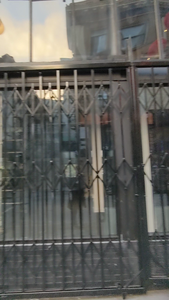
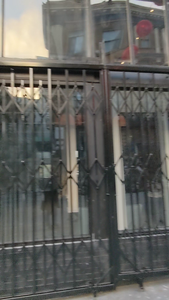
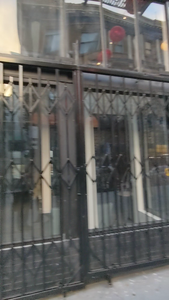

CPU times: user 1.25 s, sys: 95.4 ms, total: 1.35 s
Wall time: 9.61 s


In [7]:
%%time
%cd /notebooks

# Prepare the input images
!rm -rf /notebooks/working
!mkdir /notebooks/working
!mkdir /notebooks/working/input

init_videos = glob.glob("/notebooks/data/*.mp4")
init_videos.sort()
init_video = init_videos[1]
# init_video = "/notebooks/data/IMG_7205.MOV"

# !ffmpeg -i {init_video} -ss 00:00:00 -t 00:00:5 -vf fps=5 /notebooks/working/input/%05d.png
!ffmpeg -i {init_video} -vf fps=10 /notebooks/working/input/%05d.png

print("\n\n")
print("Number of images:", len(glob.glob("/notebooks/working/input/*.png")))

images = sorted(glob.glob('/notebooks/working/input/*.png'))
print(len(images))

show_images = [cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB) for im in images[:16]]
media.show_images(show_images, height=300, columns=4)

In [8]:
%%time
%cd /notebooks

location = Path('/notebooks/working')
images = location / 'input'
image_list = [path.split(str(images.stem) + "/")[-1] for path in sorted(glob.glob(str(images / '*')))]
outputs = location / 'sfm'
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_max']
matcher_conf = match_features.confs['superglue']

extract_features.main(feature_conf, images, image_list=image_list, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=image_list)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=image_list)

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

[2023/10/15 10:07:19 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


/notebooks
Loaded SuperPoint model


100%|██████████| 97/97 [00:07<00:00, 12.94it/s]
[2023/10/15 10:07:28 hloc INFO] Finished exporting features.
[2023/10/15 10:07:28 hloc INFO] Found 4656 pairs.
[2023/10/15 10:07:28 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 4/4656 [00:00<16:41,  4.65it/s]

In [ ]:
%cd /notebooks

!rm -rf /notebooks/working_output

!colmap image_undistorter \
	--image_path /notebooks/working/input \
	--input_path {sfm_dir} \
	--output_path /notebooks/working_output \
	--output_type COLMAP \
	# --max_image_size 2000

!mv /notebooks/working_output/sparse/ /notebooks/working_output/sparse_tmp/
!mkdir /notebooks/working_output/sparse/
!mv /notebooks/working_output/sparse_tmp/ /notebooks/working_output/sparse/0/

/notebooks

Reading reconstruction

 => Reconstruction with 74 images and 13771 points

Image undistortion

Undistorting image [1/74]
Undistorting image [2/74]
Undistorting image [3/74]
Undistorting image [4/74]
Undistorting image [5/74]
Undistorting image [6/74]
Undistorting image [7/74]
Undistorting image [8/74]
Undistorting image [9/74]
Undistorting image [10/74]
Undistorting image [11/74]
Undistorting image [12/74]
Undistorting image [13/74]
Undistorting image [14/74]
Undistorting image [15/74]
Undistorting image [16/74]
Undistorting image [17/74]
Undistorting image [18/74]
Undistorting image [19/74]
Undistorting image [20/74]
Undistorting image [21/74]
Undistorting image [22/74]
Undistorting image [23/74]
Undistorting image [24/74]
Undistorting image [25/74]
Undistorting image [26/74]
Undistorting image [27/74]
Undistorting image [28/74]
Undistorting image [29/74]
Undistorting image [30/74]
Undistorting image [31/74]
Undistorting image [32/74]
Undistorting image [33/74]
Undistorti

In [ ]:
%cd /notebooks
!python /notebooks/gaussian-splatting/train.py -s /notebooks/working_output -r 2

/notebooks


Optimizing 
Output folder: ./output/25d459e0-6 [15/10 09:05:30]
Reading camera 74/74 [15/10 09:05:34]
Converting point3d.bin to .ply, will happen only the first time you open the scene. [15/10 09:05:34]
Loading Training Cameras [15/10 09:05:34]
Loading Test Cameras [15/10 09:05:45]
Number of points at initialisation :  13771 [15/10 09:05:45]
Training progress:  23%|▋  | 7000/30000 [03:28<18:28, 20.75it/s, Loss=0.0539516]
[ITER 7000] Evaluating train: L1 0.029389501363039017 PSNR 26.447457504272464 [15/10 09:09:16]

[ITER 7000] Saving Gaussians [15/10 09:09:16]
Training progress: 100%|██| 30000/30000 [28:02<00:00, 17.83it/s, Loss=0.0371055]

[ITER 30000] Evaluating train: L1 0.013682260364294053 PSNR 32.37131462097168 [15/10 09:33:49]

[ITER 30000] Saving Gaussians [15/10 09:33:49]

Training complete. [15/10 09:34:16]
